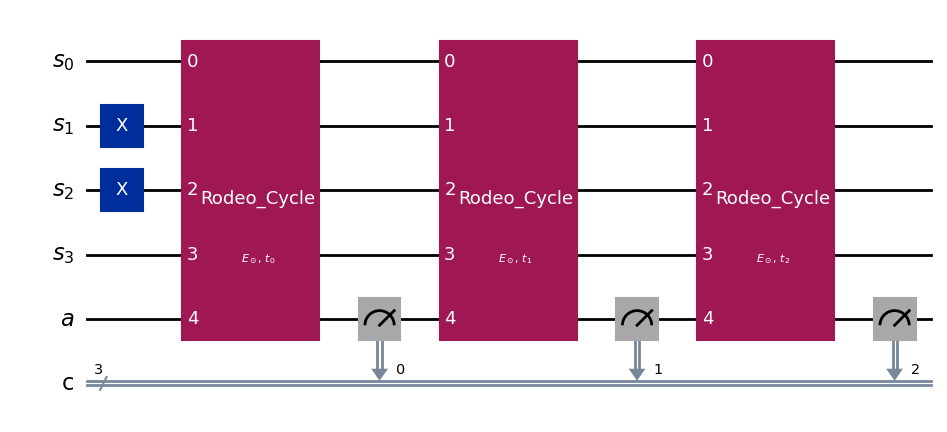

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

# # Define Fermi-Hubbard interaction gates for hopping and on-site terms
# Hopping Gate
def create_hopping_gate(J, delta_t):
    f_circ = QuantumCircuit(2)
    f_circ.h([0, 1])
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_circ.cx(0, 1)
    f_circ.h(1)
    f_circ.z(1)
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_gate = f_circ.to_gate(label='F_gate')
    
    g_circ = QuantumCircuit(2)
    g_circ.h([0, 1])
    g_circ.z(0)
    g_circ.s([0, 1])
    g_circ.h(1)
    g_circ.cx(0, 1)
    g_circ.h([0, 1])
    g_circ.z([0, 1])
    g_circ.s([0, 1])
    g_circ.h([0, 1])
    g_gate = g_circ.to_gate(label='G_gate')

    # The code below created a factor of 2 off
    # hop_circ = QuantumCircuit(2)
    # hop_circ.append(f_gate, [0, 1])
    # hop_circ.ry((J * delta_t) / 2, 0)
    # hop_circ.ry((-1*J * delta_t) / 2, 1)
    # hop_circ.append(g_gate, [0, 1])

    hop_circ = QuantumCircuit(2)
    hop_circ.append(f_gate, [0, 1])
    hop_circ.ry((J * delta_t), 0)
    hop_circ.ry((-1*J * delta_t), 1)
    hop_circ.append(g_gate, [0, 1])
    return hop_circ.to_gate(label=fr"A_gate_{J}")

# On-site interaction gate
def create_onsite_gate(U, delta_t):
    onsite_circ = QuantumCircuit(2)
    onsite_circ.cx(0, 1)
    onsite_circ.rz(2*U * delta_t, 1)
    onsite_circ.cx(0, 1)
    return onsite_circ.to_gate(label=fr"B_gate_{U}")

# Define the rodeo cycle
def rodeo_cycle(num_sites, J_value, U_value, t: Parameter, r, targ: Parameter):
    beta = t / r  # Parameter for rotation gates
    num_qubits = num_sites * 2  # Each site has two qubits (spin-up and spin-down)

    # Define quantum registers
    sys = QuantumRegister(num_qubits, 's')
    aux = QuantumRegister(1, 'a')
    qc = QuantumCircuit(sys, aux)

    # Apply Hadamard on the auxiliary qubit to create superposition
    qc.h(aux[0])

    # Trotter evolution within this single Rodeo cycle
    A_gate = create_hopping_gate(J=-J_value, delta_t=beta)
    # A_gate = create_hopping_gate(J=-2*J_value, delta_t=beta)
    B_gate = create_onsite_gate(U=U_value, delta_t=beta)

    qc.cz([sys[0], sys[1]], aux[0])
    for _ in range(r):
    
        # qc.cz([sys[0], sys[1]], aux[0])
        # Apply A_gate for hopping terms on nearest neighbors for spin-up qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            qc.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            qc.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        # Apply A_gate for hopping terms on nearest neighbors for spin-down qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            qc.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            qc.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        # qc.cz([sys[0], sys[1]], aux[0])

        # Add CX gates for every other system qubit
        for i in range(0, num_qubits, 4):
            qc.cx(aux[0], sys[i])  # Controlled X on selected system qubits
            if i + 2 < num_qubits:
                qc.cx(aux[0], sys[i + 2])

        # Apply B_gate for on-site interactions on each site
        for site in range(num_sites):
            spin_up_qubit = site * 2
            spin_down_qubit = site * 2 + 1
            qc.append(B_gate, [spin_up_qubit, spin_down_qubit])

        # # Add CX gates for every other system qubit again
        for i in range(0, num_qubits, 4):
            qc.cx(aux[0], sys[i])  # Controlled X on selected system qubits
            if i + 2 < num_qubits:
                qc.cx(aux[0], sys[i + 2])
        
    qc.cz([sys[0], sys[1]], aux[0])


    # Phase rotation based on the energy target and time sample
    qc.p(2*targ * t, aux[0])
    qc.h(aux[0])

    return qc

# Define circuit parameters
num_sites = 2
J_input = 1.5
U_input = 1.0

# Initialize cycling parameters
cycles = 3
superiterations = 5

# Initialize Qiskit parameters
target = Parameter(r'$E_\odot$')
time = [Parameter(fr'$t_{i}$') for i in range(cycles)]
si_time = [Parameter(fr'$st_{j}$') for j in range(superiterations)]
steps = 5

# Create a list of target energies at the same length of the cycle
targ_list = [target] * cycles

# Create registers and circuit
classical = ClassicalRegister(cycles, 'c')
aux = QuantumRegister(1, 'a')
sys = QuantumRegister(num_sites * 2, 's')
circuit = QuantumCircuit(sys, aux, classical)

circuit.x([sys[1], sys[2]])

# Create circuit with rodeo cycles
for j in range(cycles):
    rodeo_gate= rodeo_cycle(num_sites=2, J_value=J_input, U_value=U_input, t=time[j], r=steps, targ=target)
    circuit.append(rodeo_gate.to_gate(label = fr'Rodeo_Cycle'), range(num_sites * 2 + 1))
    circuit.measure(aux, classical[j])  # Ensure that the measurement of `aux` qubit is mapped to the `j`-th classical bit
    

circuit.draw('mpl')


In [2]:
import numpy as np

def create_super_iterations(time_sample: float, iterations: int):
    times_list = np.zeros(iterations + 1)
    
    time = time_sample
    
    for i in range(0, iterations+1):
        time /= 2  # Halve the time each iteration
        times_list[i] = time
    
    return times_list


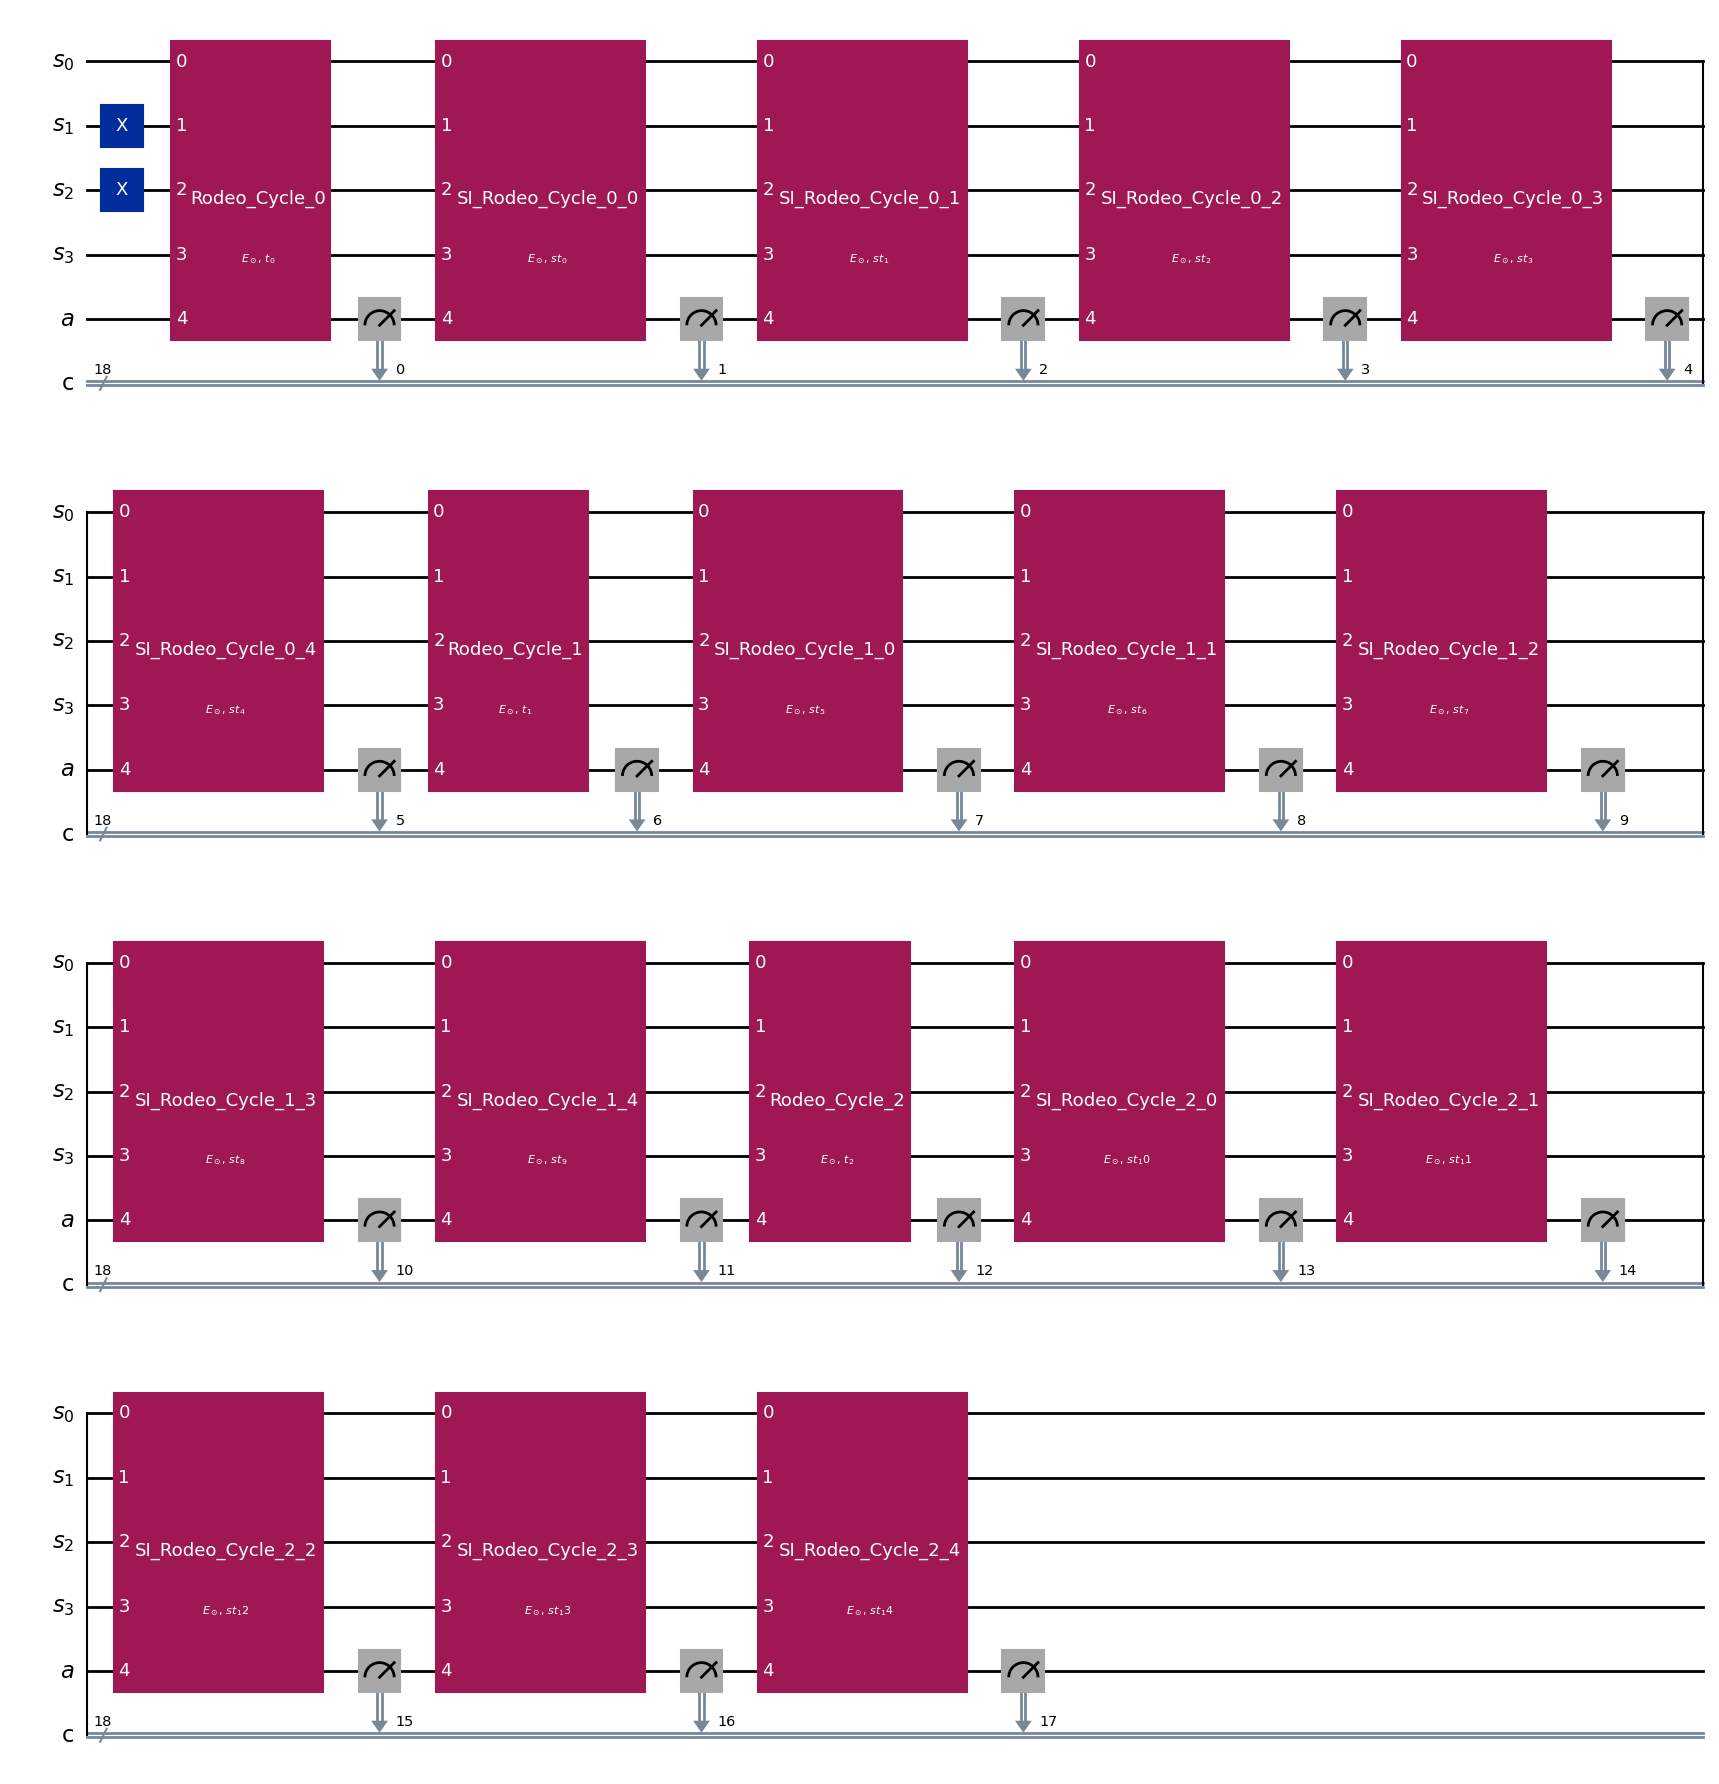

In [4]:
# Define circuit parameters
num_sites = 2
J_input = 4
U_input = 1.0

# Initialize cycling parameters
cycles = 3
iterations = 5

# Initialize Qiskit parameters
target = Parameter(r'$E_\odot$')
time = [Parameter(fr'$t_{i}$') for i in range(cycles)]
si_time = [Parameter(fr'$st_{j}$') for j in range(cycles * iterations)]
steps = 5

# Create registers and circuit
classical = ClassicalRegister(cycles * (1 + iterations), 'c')
aux = QuantumRegister(1, 'a')
sys = QuantumRegister(num_sites * 2, 's')
circuit = QuantumCircuit(sys, aux, classical)

circuit.x([sys[1], sys[2]])

# Create circuit with alternating rodeo cycles and super iterations
classical_idx = 0
super_idx = 0 

for j in range(cycles):
    rodeo_gate = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input, t=time[j], r=steps, targ=target)
    circuit.append(rodeo_gate.to_gate(label=fr'Rodeo_Cycle_{j}'), range(num_sites * 2 + 1))
    circuit.measure(aux, classical[classical_idx])
    classical_idx += 1 

    # Add super iteration cycles with si_time
    for k in range(iterations):
        rodeo_gate_si = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input, t=si_time[super_idx], r=steps, targ=target)
        circuit.append(rodeo_gate_si.to_gate(label=fr'SI_Rodeo_Cycle_{j}_{k}'), range(num_sites * 2 + 1))
        circuit.measure(aux, classical[classical_idx])
        classical_idx += 1 
        super_idx += 1 

# Draw the circuit
circuit.draw('mpl')
